In [32]:
import numpy as np
import math

import matplotlib.pyplot as plt

from itertools import cycle
import operator
from IPython.display import display, clear_output

from sympy import *
init_printing()

# Electrical

In [2]:
Im, It = symbols('I_m I_t')
rm, rb = symbols('r_m r_b')
Vb, Vemf, Va = symbols('V_b V_emf V_a')
nm = symbols('n_m')
wr = symbols('omega_r')
ke, km = symbols('k_e k_m')

In [3]:
VaEqu = Eq(Va, Vb - It*rb)
VaEqu

In [4]:
VbEqu = VaEqu.subs(Va, Im*rm + ke*wr).subs(Im, It/nm)
VbEqu

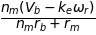

In [5]:
ItVal = solve(VbEqu, It)[0]
ItVal

# Kinematics

In [6]:
Tr, Tf, Tw, Tm = symbols('tau_r tau_f tau_w tau_m')
g = symbols('g')
Jr = symbols('J_r')
alpha, m, rw = symbols('alpha m r_w')
v = symbols('v')
gamma = symbols('gamma')
Mi = symbols('M_i')
ww = symbols('omega_w')

Ts, Is, Io, wo, Vm = symbols('T_s I_s I_o w_o V_m', constant=True, real=True)
# Stall Torque, Stall Current, Free current, number of motors, nominal voltage

In [7]:
TwEqu = Eq(Tw, (m*rw**2 + Jr) * alpha + gamma*ww + Tf)
TwEqu

In [8]:
TwEqu2 = TwEqu.subs(Tw, Tm * g)
TwEqu2

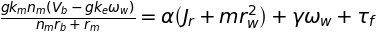

In [9]:
TwEqu3 = TwEqu2.subs(Tm, ItVal*km).subs(wr, ww*g)
TwEqu3

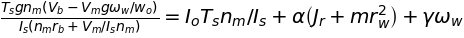

In [10]:
KmDef = Ts / Is
KeDef = Vm / wo
RmDef = Vm / (Is * nm)
TfDef = Ts * Io * nm / Is

TwEqu4 = TwEqu3.subs([(km, KmDef), (ke, KeDef), (rm, RmDef), (Tf, TfDef)])
TwEqu4

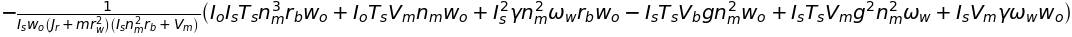

In [11]:
AlphaVal = solve(TwEqu4, alpha)[0].factor()
AlphaVal

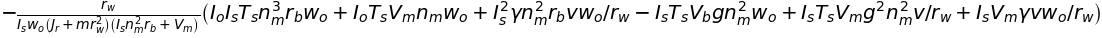

In [12]:
AcelVal = rw * AlphaVal.subs(ww, v / rw)
AcelVal

# Substitution

In [19]:
# Motor Specs
stall_torque = 4.2 / 40 # Stall torque (Nm)
motor_num = 4 # Number of motors
stall_current = 8.5 # Stall current (amps)
no_load_current = 0.2 # No load current (amps)
nominal_voltage = 12 #Nominal voltage (volts)
free_speed = 150 * 40 # Free motor speed (rpm)

# Robot Specs
mass = 0.453592 * 5 # Robot mass (kg)
radius = .0064 # Wheel diameter (m)
inertia = 0.00 # Wheel inertia (Kg m^2)
wheel_efficiency = 0.7 # Wheel efficiency (Mecanum = 0.7, tank = 1)
gamma_val = 0.001

# Battery Specs
batery_resistance = 0.1 # Battery Resistance (ohms)
operating_voltage = 12.7 # Operating battery voltage (volts)

In [20]:
subList = [(Ts, stall_torque), (nm, motor_num), (Is, stall_current), (Io, no_load_current), 
                 (Vm, nominal_voltage), (wo, free_speed), (rw, radius), (rb, batery_resistance), 
                 (E, wheel_efficiency), (Vb, operating_voltage), (Jr, inertia), (m, mass), (gamma, gamma_val)]

Acel3 = AcelVal.subs(subList)
Acel3.expand()

# Useable Function

In [22]:
const, gArg, vArg, ggvArg = Acel3.args

gVal = gArg.subs(g, 1)
vVal = vArg.subs(v, 1)
ggvVal = ggvArg.subs(((g, 1), (v, 1)))

print("Const = " + str(const))
print("gArg = " + str(gArg) + " -> " + str(gVal))
print("vArg = " + str(vArg) + " -> " + str(vVal))
print("ggvArg = " + str(ggvArg) + " -> " + str(ggvVal))

def aceleration(vel, gRatio):
    return const + gVal*gRatio + vVal*vel + ggvVal*gRatio**2*vel

def timeAtRatio(targetDist, ratio):
    t_acum = 0
    x_acum = 0
    v_acum = 0
    dt= 0.0001
    while x_acum < targetDist:
        a = aceleration(v_acum, ratio)

        if a < 0:
            print(a)
            print('Error: not enough torque at: a=' + str(ratio) + ", v=" + str(v_acum))
            return None 
        
        v_acum += a*dt
        x_acum += v_acum*dt
        t_acum += dt
        
        if t_acum > 10:
            print('Error: took more than 10 seconds')
            return None
    return t_acum

def speedAtDistance(dist, ratio):
    t_acum = 0
    x_acum = 0
    v_acum = 0
    dt= 0.0001
    
    while x_acum < dist:
        a = aceleration(v_acum, ratio)

        if a < 0:
            print(a)
            print('Error: not enough torque at: a=' + str(ratio) + ", v=" + str(v_acum))
            return None 
        
        v_acum += a*dt
        x_acum += v_acum*dt
        t_acum += dt
        
        if t_acum > 10:
            print('Error: took more than 10 seconds')
            return None
    return v_acum

Const = -0.680839894468520
gArg = 57.4192707874037*g -> 57.4192707874037
vArg = -10.7647676766786*v -> -10.7647676766786
ggvArg = -1.41287575756407*g**2*v -> -1.41287575756407


NameError: name 'wheelType' is not defined

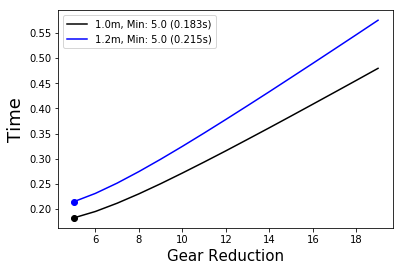

In [33]:
minRatio = 5
maxRatio = 20
targetDist = [1, 1.2] # meters


colors = cycle(["black", "blue", "grey", "silver", "lime", "green", "olive"])
fig = plt.figure()
ax = fig.add_subplot(111)

ratios = np.arange(minRatio, maxRatio, 1)

for dist in targetDist:
    time = [timeAtRatio(dist, x) for x in ratios]
        
    index, minTime = min(enumerate(time), key=operator.itemgetter(1))
    minRatio = ratios[index]
    color = next(colors)
    
    label = '%.1fm, Min: %.1f (%.3fs)' %(dist, minRatio, minTime)
    ax.plot(ratios, time, label=label, color=color)
    ax.plot(minRatio, minTime, '-o', color=color)
        
clear_output()
    
ax.set_xlabel("Gear Reduction", fontsize=15)
ax.set_ylabel("Time", fontsize=18)
ax.legend(loc="best")
ax.set_title('%s  |  Mass = %.1f lbs' %(wheelType, mass*2.20462), fontsize=13)
ax.margins(0.1)
fig.tight_layout()
plt.show()